# 304.2. Abell 360 red sequence galaxies

<div>
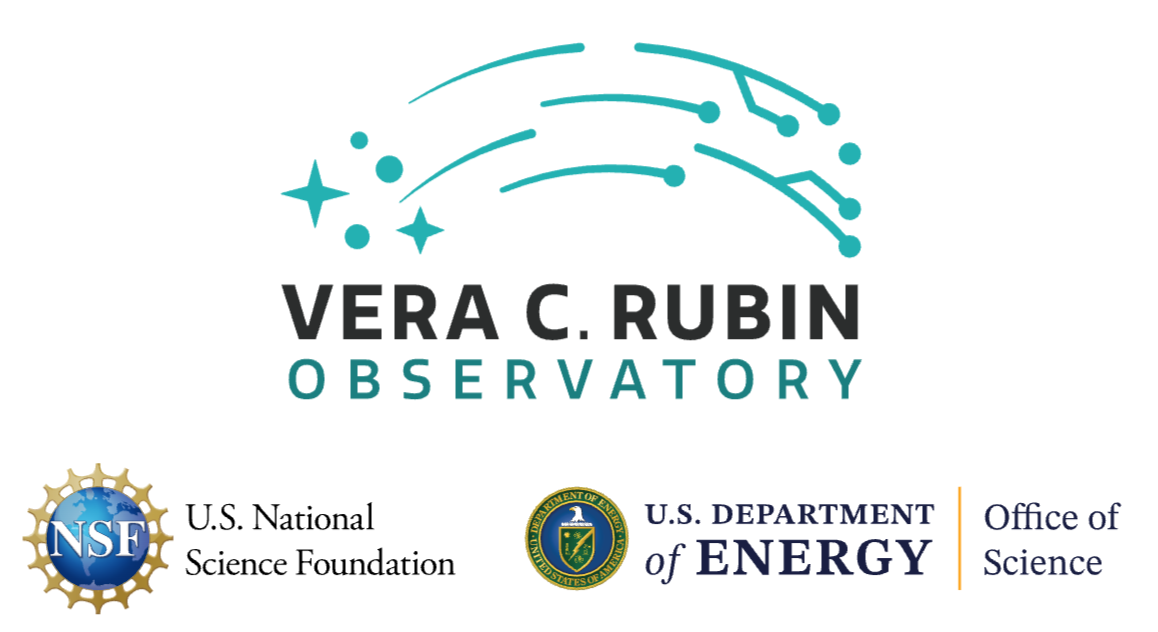
</div>
For the Rubin Science Platform at data.lsst.cloud. <br>
Data Release: <a href="https://dp1.lsst.io/">Data Preview 1</a> <br>
Container Size: Large <br>
LSST Science Pipelines version: r29.2.0 <br>
Last verified to run: 2025-09-02 <br>
Repository: <a href="https://github.com/lsst/tutorial-notebooks">github.com/lsst/tutorial-notebooks</a> <br>

**Learning objective:** How to identify the red sequence of galaxy cluster Abell 360.

**LSST data products:** `deep_coadd` images, `Object` table

**Packages:** `lsst.daf.butler`, `lsst.rsp`, `lsst.afw.display`.

**Credit:**
Developed by Shenming Fu, inspired by Céline Combet's Notebook for [ComCam Clusters](https://github.com/lsst-sitcom/comcam_clusters). Part of this notebook will be used for a journal article about a Rubin view of A360 (led by Anja von der Linden).

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction

Abell 360 (A360) is a known rich cluster (redshift=0.22) covered by DP1. 

Find red sequence galaxies of A360 using color-magnitude diagrams (CMDs) and color-color plots (CCs). Visualize those galaxies in the coadded images. 

**Related tutorials:** The 100-level tutorials on using the butler and TAP. The 200-level tutorials on object tables and deep coadds.

### 1.1. Import packages

Import general packages (`numpy`, `matplotlib`, `astropy`), the LSST packages for bulter, TAP, and display.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from lsst.daf.butler import Butler
from lsst.rsp import get_tap_service, retrieve_query
import lsst.afw.display as afwDisplay

### 1.2. Define parameters and functions
Set up Firefly for displaying images.

In [ ]:
afwDisplay.setDefaultBackend("firefly")
afw_display = afwDisplay.Display(frame=1)

Get the butler via repo and collection.

In [ ]:
butler = Butler("dp1", collections="LSSTComCam/DP1")
assert butler is not None

Get the TAP service.

In [ ]:
service = get_tap_service("tap")
assert service is not None

## 2. Load data



The Abell 360 Brightest Central Galaxy (BCG) is known at RA=37.865deg, DEC=6.982deg. 

Provide the center coordinates and the range in degree for making a cone search for the catalog.

In [ ]:
ra_bcg = 37.865
dec_bcg = 6.982

range_deg = 0.1 

Make a cone search for the catalog. This takes a few seconds. 

In [ ]:
query = "SELECT objectId, coord_ra, coord_dec, x, y, refExtendedness, " \
        "r_cModelMag, i_cModelMag, z_cModelMag, " \
        "r_cModelMagErr, i_cModelMagErr, z_cModelMagErr, " \
        "r_cModelFlux/r_cModelFluxErr AS r_cModel_SNR, " \
        "i_cModelFlux/i_cModelFluxErr AS i_cModel_SNR, " \
        "z_cModelFlux/z_cModelFluxErr AS z_cModel_SNR, " \
        "r_cModel_flag, i_cModel_flag, z_cModel_flag " \
        "FROM dp1.Object " \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " \
        "CIRCLE('ICRS', %f, %f, %f)) = 1 "%(ra_bcg, dec_bcg, range_deg)

job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

In [ ]:
assert job.phase == 'COMPLETED'
obj_cat = job.fetch_result().to_table()
print(len(obj_cat))

Use the butler to get the deep coadd image in `r` band for visualization. 

In [ ]:
band = "r"
dataset_refs = butler.query_datasets("deep_coadd",
                                     where="band.name = band AND \
                                     patch.region OVERLAPS POINT(ra, dec)",
                                     bind={"band": band, "ra": ra_bcg, "dec": dec_bcg})
for ref in dataset_refs:
    print(ref.dataId)

deep_coadd = butler.get(dataset_refs[0])

## 3. Plot data

### 3.1. Select extended objects


Select the objects that do not have flags and negative fluxes to ensure the quality, and use `extendedness` to get galaxies. Use the `CModel` photometry [(Bosch et al. 2018)](https://ui.adsabs.harvard.edu/abs/2018PASJ...70S...5B/abstract) for galaxies.  

Consider three bands `r`, `i`, `z`, and consider CMDs in colors `r-i` and `i-z`, where RS is clear to see. Finding RS in multiple colors instead of a single color improves the quality of RS galaxy selection [(Fu et al. 2024)](https://ui.adsabs.harvard.edu/abs/2024ApJ...974...69F/abstract).


In [ ]:
band_list = ["r", "i", "z"]

sel = obj_cat["refExtendedness"] == 1

for band in band_list:
    sel &= obj_cat[f"{band}_cModel_flag"] == False
   
obj_cat = obj_cat[sel]

### 3.2. Plot magnitude histograms

Visualize the histogram of magnitudes in each band and find the peak. Also, plot the magnitude vs. signal-to-noise-ratio (SNR) for comparision. At the magnitude histogram peak, the SNR is about 5 to 10. 

In [ ]:
for band in band_list:

    fig, ax = plt.subplots(figsize=(4,3), layout="constrained")

    mag_lim_min, mag_lim_max = 15, 32
    bins = np.linspace(mag_lim_min, mag_lim_max, 41)
    mid = 0.5 * (bins[1:] + bins[:-1])
    
    count, _, _ = ax.hist(obj_cat[f"{band}_cModelMag"], bins=bins, 
                          histtype="step")
    mid_max = mid[np.argmax(count)]
    print(band, "peak: ", mid_max)
    ax.axvline(mid_max, c="r", ls="--", label="peak")
    
    ax.set_yscale("log")
    ax.set_xlabel("Magnitude")
    ax.set_ylabel("Count")
    ax.set_xlim([mag_lim_min, mag_lim_max])

    ax2 = ax.twinx()
    ax2.scatter(obj_cat[f"{band}_cModelMag"], obj_cat[f"{band}_cModel_SNR"], 
                s=1, c="k")
    ax2.axhline(5, c="g", ls=":", label="SNR=5")
    
    ax2.set_yscale("log")
    ax2.set_ylabel("SNR")

    plt.title(f"{band} band")

    ax.legend(loc="lower left")
    ax2.legend(loc="upper right")

> **Figure 1:** Distribution of magnitudes, and relation with the signal-to-noise-ratio (SNR).

### 3.3. Plot color-magnitude diagrams

It can be seen that the RS locates at `r-i`=0.5 and `i-z`=0.25, respecitively. Plot lines for RS, and select bright galaxies (< 23 mag) near RS. 

In [ ]:
color_dict = {
    "ri": 0.5,
    "iz": 0.25,
}

eps = 0.1 
sel_rs = np.array([True] * len(obj_cat))
mag_max = 23

for ind in range(len(band_list)-1):

    band1 = band_list[ind]
    band2 = band_list[ind+1]

    fig, ax = plt.subplots(figsize=(4,3), layout="constrained")

    ax.scatter(obj_cat[f"{band1}_cModelMag"], 
               obj_cat[f"{band1}_cModelMag"] - obj_cat[f"{band2}_cModelMag"], 
               marker=".", s=0.3)
    
    ax.set_xlim([18,25])
    ax.set_ylim([-2,2])
    
    ax.set_xlabel(band1)
    ax.set_ylabel(f"{band1}-{band2}")

    color = color_dict[f"{band1}{band2}"]
    ax.axhline(color - eps, ls="--", c="k", alpha=0.3)
    ax.axhline(color + eps, ls="--", c="k", alpha=0.3)

    sel_rs &= np.abs(obj_cat[f"{band1}_cModelMag"] - obj_cat[f"{band2}_cModelMag"] - color) < eps
    sel_rs &= obj_cat[f"{band1}_cModelMag"] < mag_max

> **Figure 2:** CMDs and RS in `r-i` and `i-z`.

### 3.4. Plot color-color diagrams

Next, plot galaxies in the color-color space, and highlight the RS galaxies. 

In [ ]:
ind = 0
band1 = band_list[ind]
band2 = band_list[ind+1]
band3 = band_list[ind+2]

fig, ax = plt.subplots(figsize=(4,3), layout="constrained")

ax.scatter(obj_cat[f"{band1}_cModelMag"] - obj_cat[f"{band2}_cModelMag"], 
           obj_cat[f"{band2}_cModelMag"] - obj_cat[f"{band3}_cModelMag"], 
           marker=".", s=0.5)

ax.scatter(obj_cat[f"{band1}_cModelMag"][sel_rs] - obj_cat[f"{band2}_cModelMag"][sel_rs], 
           obj_cat[f"{band2}_cModelMag"][sel_rs] - obj_cat[f"{band3}_cModelMag"][sel_rs], 
           marker=".", s=0.3, label="RS")

ax.axvline(color_dict[f"{band1}{band2}"], ls="--", c="k", alpha=0.3)
ax.axhline(color_dict[f"{band2}{band3}"], ls="--", c="k", alpha=0.3)

ax.legend()

ax.set_xlim([-1,2])
ax.set_ylim([-1,2])

ax.set_xlabel(f"{band1}-{band2}")
ax.set_ylabel(f"{band2}-{band3}")

> **Figure 3:** RS in `r-i` vs `i-z` color-color space.

## 4. Red sequence galaxies

### 4.1. Spatial distribution

Plot the 2D distribution of those RS galaxies and use color to show the magnitude. 
There are some clumps in the distribution. 

In [ ]:
fig, ax = plt.subplots(figsize=(4,3), layout="constrained")
im = ax.scatter(obj_cat["coord_ra"][sel_rs], 
                obj_cat["coord_dec"][sel_rs], 
                s=2., 
                c=obj_cat["r_cModelMag"][sel_rs], 
                cmap="viridis",
          )
ax.invert_xaxis()
ax.set_xlabel("RA [deg]")
ax.set_ylabel("DEC [deg]")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("r [mag]")

> **Figure 4:** 2D RS galaxies distribution.

### 4.2. Radial density profile

Plot the number density (number per unit area) of RS galaxies as a function of radial distance. 
The density drops when the radial distance gets larger. 

In [ ]:
coord_obj = SkyCoord(obj_cat["coord_ra"], 
                     obj_cat["coord_dec"])
coord_bcg = SkyCoord(ra_bcg * u.deg, dec_bcg * u.deg)
sep = coord_bcg.separation(coord_obj)
radial_distance = sep.arcmin[sel_rs]

bin_num = 6
bins = np.linspace(0, range_deg*60, bin_num)
mid = 0.5 * (bins[1:] + bins[:-1])
area = (bins[1:]**2 - bins[:-1]**2) * np.pi

count, _ = np.histogram(radial_distance, bins=bins)

fig, ax = plt.subplots(figsize=(4,3), layout="constrained")
ax.scatter(mid, count/area)
ax.set_xlabel("Radial distance [arcmin]")
ax.set_ylabel("Density [arcmin^-2]")

> **Figure 5:** Radial number density profile of RS galaxies.

### 4.3. Magnitude histogram

Plot the magnitude histogram of RS galaxies in each band. This is similar to the luminosity function, because galaxy member galaxies are almost at the same distance to the observer.

In [ ]:
fig, ax = plt.subplots(figsize=(4,3), layout="constrained")

bins = np.linspace(15, mag_max, 21)

for band in band_list:
    ax.hist(obj_cat[f"{band}_cModelMag"][sel_rs], bins=bins, 
            histtype="step", label=band)

ax.set_yscale("log")
ax.set_xlabel("Magnitude")
ax.set_ylabel("Count")
ax.legend()

> **Figure 6:** Magnitude histogram of RS galaxies.

### 4.4. Objects on the image

Plot galaxies on the coadd image.

First, display the image in the Firefly tab and set the mask plane to be transparent.

In [ ]:
afw_display.mtv(deep_coadd)
afw_display.setMaskTransparency(100)

Overplot objects. Leave some blank region near the edge.

In [ ]:
bbox = deep_coadd.getBBox()

sel_inside =  obj_cat["x"][sel_rs] < (bbox.getMaxX()-100)
sel_inside &= obj_cat["y"][sel_rs] < (bbox.getMaxY()-100)

for i in obj_cat[sel_rs][sel_inside]:
    afw_display.dot("o", 
                i["x"],
                i["y"], 
                size=20, ctype="red")

The deep coadd image which is displayed in the Firefly tab does not cover the entire cluster, as Abell 360 is very large.

<div>
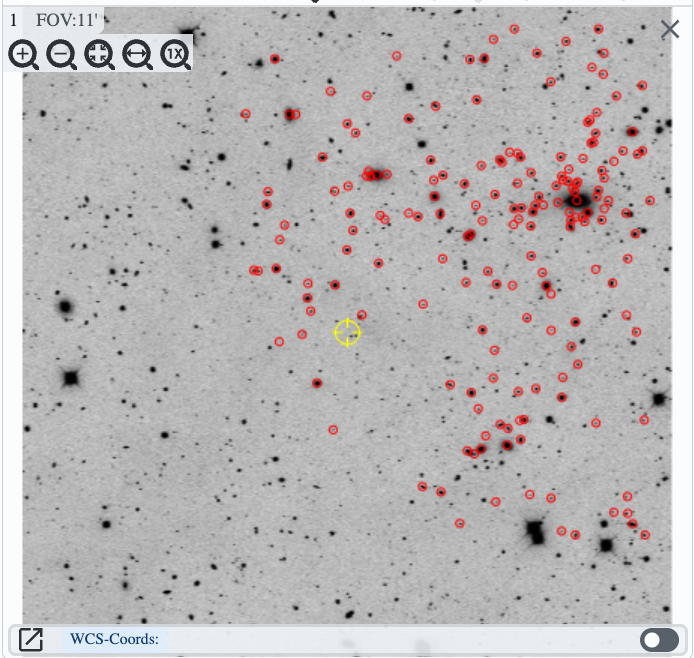
</div>

> **Figure 7:** A screenshot of the Firefly display window as it should appear for the `deep_coadd` image that overlaps the center of Abell 360, with red sequence members marked with red circles.